# Discovering Patterns in the Russian Housing Market for Analysis and Prediction

## 3804ICT Assignment Part 2 | K-Means Clustering | Trimester 2, 2019

Joshua Russell (s5057545) | joshua.russell2@griffithuni.edu.au

Joshua Mitchell (s5055278) | joshua.mitchell4@griffithuni.edu.au

Hayden Flatley (s5088623) | hayden.flatley@griffithuni.edu.au

## Introduction

#### 1.1 Aim

The aim of this investigation is to find interesting patterns and similarities between attributes of the Russian Housing Market with the K-Means Clustering algorithm. A cluster is a collection of data objects, where objects in the same cluster are similar, and are dissimilar to objects in other clusters. Interesting distributions accross multiple dimensions or attributes can be discovered and leveraged to make predictions on new data. For this investigation, clustering will be used to group similar houses for the purpose of recommending new properties on the market to buyers. The data lacks classification on the motivation of property purchases, such as rental property, family home, short term flipping. Users who have previously shown interest in properties belonging to a common cluster can then be shown new properties belonging to the same clusters, which will hopefully share patterns of attributes common to the kind of properties they are interested in.

#### 1.2 K-Means Clustering

The K-Means Clustering algorithm uses a partioning approach to separate the given data points into K clusters. It is a centroid based clustering algorithm, which means it constructs a set of centroid vectors describing the center point for each cluster. The data points are then assigned to the cluster with the minimum distance to the centroid vector. After creating the optimised cluster centers, new data points, or houses, can be assigned to their cluster and treated as similar to the other properties in that cluster. 

The centroids are constructed in an iterative approach. The data points are initially randomly assigned to k equally sized clusters. The centroids of these initial clusters are then calculated by finding the average of each attribute in each cluster. 

$$ m_{i}^{(t+1)} = \frac{1}{|S_{i}^{(t)}|} \sum_{x_j \in S_{i}^{(t)}} x_j$$

The data points are then reassigned to the cluster with minimum distance to the centroid. This is most commonly calculated with the Euclidean distance.

$$ \sqrt{\sum_{i=1}^{n}(q_i-p_i)^2} $$

The following function assigns each datapoint x to its cluster S for iteration t, such that the distance between x and the centroid for S is less than the distance for all other cluster centroids.

$$ S_{i}^{(t)} = \{x_p : ||x_p-m_i^{(t)}||^2 \leq ||x_p-m_j^{(t)}||^2  \forall j,1\leq j \leq k\} $$

Doing so constructs a Voronoi diagram, where a plane is partitioned into subsets where each region contains the points nearest to the seed or center point of that region.

<img src="Images/Voronoi_diagram.png" width="200">


To converge on the partitions which best group points that are similar and separates points which are dissimilar, the previous two steps will be repeated until the clusters are unchanged. This means that when performing the reassignment step all points remain in their same cluster. This algorithm is often reffered to as an EM algorithm, where the expectation step E refers to the assignment, while the maximisation step M refers to the cluster centre recalculation.

The three metrics which define the quality of this clustering algorithm on a dataset are the clustering tendency of the data, choosing the optimal k, and the quality of the clusters. Data which has clustering tendency is data which has a non-uniform distribution. Attributes from the dataset will first have to be tested for this quality with the Hopkins statistic. 

The value K must be given, which is a flaw of the algorithm. A k value that is too high will result in minor patterns caused by noise to be identified as clusters. A k value which is too low will miss clusters and group sets of data together which should be classified as separate. As such, additional metrics must be used to arrive at an optimal k number of clusters for a set of attributes. These metrics quantify the similarity within clusters and the dissimilarity between clusters to find interesting clusters and relationships. Upon finding the optimal attributes with high clustering tendency, and the optimal number of clusters, these heuristics will be used to arrive at the most interesting clusters.

There will also be variation in the clusters created due to the initial random assignment of cluster centers. It is common to perform several iterations on a set of attributes with the same K value, but with different random initial centroids. Library implementations include options for random seeds to create this variation.



#### 1.3 References
* 20 points and their Voronoi cells (larger version below), Balu Ertl https://en.wikipedia.org/wiki/Voronoi_diagram#/media/File:Euclidean_Voronoi_diagram.svg



## 2. Preprocessing

#### 2.1 Importing Libraries and Data
Here we import library modules, load the Russian housing market datasets and preprocess the data for the task of k-means clustering. The attributes to be used will be decided based on attribute clustering tendency.

In [197]:
#Imports
import math
import folium
import random
import statistics
import random
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.cluster
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import mlxtend.cluster
import sklearn.metrics
from random import sample
from numpy.random import uniform
from math import isnan

In [198]:
# Read in data set split into train and test files
df_test = pd.read_csv("Data/test.csv")
df_train = pd.read_csv("Data/train.csv")
# Concatenate test and train DataFrames
df = pd.concat([df_train, df_test], sort=False, ignore_index=True)

Here we perform some basic data cleaning taken from Part 1

In [199]:
# Where the floor is null set to 1
df.loc[df.floor.isnull(), 'floor'] = 1
# Build Year
df = df.drop(df[(df.build_year > 2019) | (df.build_year < 1000)].index)
# Set floors less than equal to 0 to 1
df.loc[df.floor <= 0] = 1
# Drop properties where the price is 0
df = df.drop(df[df.price_doc == 0].index) 

#### 2.2 Attribute Selection

#### Hopkin's Statistic
As stated above, before applying clustering algorithms to a dataset it must be ensured that the attributes have some indication of clustering tendency. The most common algorithm used to calculate this clustering tenency metric is the Hopkin's Statistic. This statistic represents how closely a dataset of any dimension follows a uniformally random distribution. Randomly distributed data will generally produce a result around 0.5, with lower values inferring a higher clustering tendency. 
Steps to calculate this value are as follow:
* X is the dataset of n points
* take a sample of x, of size m. this sample has points $x_i$
* create an equal sized set Y, with uniformally randomly distributed points
* Calculate $u_i$, which is the distance of $y_i$ from Y, to the nearest neighbour in X.
* Calculate $w_i$, which is the distance of $x_i$ from X, to it's nearest neighbour in X.


With these values Hopkin's Statistic H is calculated as:

$$ H = \frac{\sum_{i=1}^m u_i^d}{\sum_{i=1}^m u_i^d+\sum_{i=1}^m w_i^d} $$

The function below accepts a dataset of any shape and returns the clustering tendency for that dataset.

In [201]:
# Clustering tendency with Hopkins Statistic
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    #n = len(X) # rows
    n = 1000
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/Solution. 

Here we iterate through each attribute in the dataset and calculate it's Hopkin's statistic. We then sort them by their clustering tendency to display which attributes will be the most interesting to explore with our implementations.

In [202]:
hopkins_vals = []
for i in df.columns.values:
    #for j in range(i+1,len(attributes),1):
    if np.issubdtype(df[i].dtype, np.number):
        dfHop = df[[i]].dropna()
        h = hopkins(dfHop)
        hopkins_vals.append([i, h])

Text(0.5, 1.0, 'Attribute Cluster Tendency')

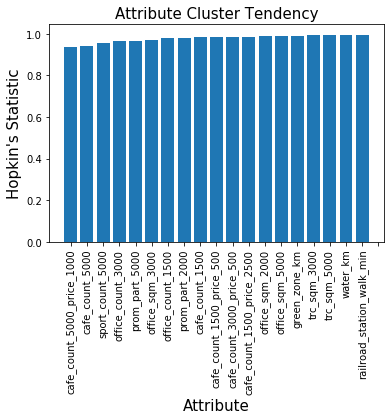

In [203]:
highestHopkinsAttributes = sorted(hopkins_vals, key=lambda x: x[1])[:60]
hopkinsToPlot = highestHopkinsAttributes[:20]
del hopkinsToPlot[0]
hopkinsToPlot_x = [h[0] for h in hopkinsToPlot]
hopkinsToPlot_y = [h[1] for h in hopkinsToPlot]
plt.bar(hopkinsToPlot_x, hopkinsToPlot_y)
x = list(range(20))
plt.xticks(x,hopkinsToPlot_x, rotation='vertical')
plt.xlabel("Attribute",fontsize=15)
plt.ylabel("Hopkin's Statistic",fontsize=15)
plt.title("Attribute Cluster Tendency",fontsize=15)

We then select our attributes to be exlored according to these tendencies. To avoid redundancy similar attribute types are excluded. We've also included the price_doc for exploring any relationships with this attribute.

In [204]:
attributes = ['prom_part_5000', 'leisure_count_3000', 'cafe_count_5000_price_1500', 'office_count_1000',
              'trc_sqm_5000', 'big_road1_km', 'green_part_500', 'detention_facility_km',
             'railroad_station_walk_km', 'water_km', 'museum_km', 'oil_chemistry_km', 'incineration_km', 
              'metro_min_avto', 'market_shop_km', 'price_doc']

The last preprocessing we apply to the set is creating a normalised version of the attribute dataset. When clustering you want to be able to cluster multiple dimensions where not every dimension will be of the same scale. By normalising we can cluster these with equal weighting and convert the scale back after to observe the relationships. Below we simply use min max normalisation on each attribute.

In [205]:
kmc_df = df[attributes].dropna()
kmc_norm_df=(kmc_df-kmc_df.min())/(kmc_df.max()-kmc_df.min())

#### References
* [13]Matevzkunaver. (2017). Hopkins test for cluster tendency. Retrieved 4 October 2019, from
https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/

## 3. Library Solutions

The two libraries used to implement K-Means Clustering are Scikit-Learn and MLXTEND. 

#### 3.1 Scikit-Learn

In [206]:
def scikitlearnClustering(df, classes, k, returnLabels = False, random_state=0):
    """ Scikit-Learn K-Means Clustering Implementation
        :param df: the dataframe containing columns corresponding with the classes list
        :param classes: list of the column names to be clustered
        :param k: the number of clusters to be found
        :param returnLabels: will have the list of cluster labels for each data point returned
        :param random_state: allows seeding of the starting cluster centers, can be changed for random restarts to
                             avoid converging on local minima.
        
        When returnLabels == false function Will return a list of clusters where first index gives the cluster,
        second index gives the class and the third index gives the value
    """
    #number of classes
    num_c = len(classes)

    df_kmc = df[classes].dropna()
    np_kmc = df_kmc.to_numpy()
    
    #find the clusters from the data
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(np_kmc)
    #return the labels if specified to
    if returnLabels:
        return kmeans.labels_

    #format data into 3d list representing the clusters
    clusterPoints = [[[] for c in range(num_c)] for _ in range(k)]
    for c in range(len(kmeans.labels_)):
        for i in range(num_c):
            clusterPoints[kmeans.labels_[c]][i].append(np_kmc[c][i])

    #return the cluster representation
    return clusterPoints


#### 3.2 MLXTEND

In [207]:
def mlxtendClustering(df, classes, k, returnLabels=False):
    """ Scikit-Learn K-Means Clustering Implementation
        :param df: the dataframe containing columns corresponding with the classes list
        :param classes: list of the column names to be clustered
        :param k: the number of clusters to be found
        :param returnLabels: will have the list of cluster labels for each data point returned
        
        When returnLabels == false function Will return a list of clusters where first index gives the cluster,
        second index gives the class and the third index gives the value
    """
    # num_c is the number of classes or dimensions
    num_c = len(classes)

    # dataframe and numpy conversion of dataframe to be used
    df_kmc = df[classes].dropna()
    np_kmc = df_kmc.to_numpy()
    
    # fit the given data to its clusters
    # max_iter sets the maximum number of iterations the algorithm will take without converging
    kmeans = mlxtend.cluster.Kmeans(k=k,max_iter=1000).fit(np_kmc)
    
    # extract the labels into an array from the dictionary
    labels = [0 for _ in range(len(np_kmc))]
    for key in kmeans.clusters_.keys():
        for i in kmeans.clusters_[key]:
            labels[i] = key
    # return the labels if specified to 
    if returnLabels:
        return labels
    # format data into 3d list representing clusters
    kmeans.clusters_
    clusterPoints = [[[] for c in range(num_c)] for _ in range(k)]
    for key in list(kmeans.clusters_.keys()):
        for i in kmeans.clusters_[key]:
            for c in range(num_c):
                clusterPoints[key][c].append(np_kmc[i][c])
    # return the formatted clusters
    return clusterPoints

## 4. Manual Solution

In [208]:
class ManualKMeansCluster:
    # Manual implementation of KMeans Clustering
    def __init__(self, k):
        # Initialse empty clusters array and k value
        self.k = k
        self.clusters = []
    
    # fit accepts a 2d numpy array with attributes in columns and data points in rows
    def fit(self, data):
        # number of rows/datapoints
        self.dataLen = len(data)
        # number of columns/attributes
        self.numc = len(data[0])
        # assign each datapoint to a cluster, datapoints which have rows close together will be in the same cluster
        # tries to give an even amount of points to each cluster
        for k_ in range(self.k):
            for c in range(self.dataLen//self.k):
                self.clusters.append(k_)
        # append the rest of the points to the last cluster
        while(len(self.clusters) != self.dataLen):
            self.clusters.append(self.k-1)
        
        # while datapoints have changed cluster recompute the centers
        while self.recomputeCenters(data):
            pass
        
        # clusterPoints is a 3d array where index 1 represents the cluster, index 2 represents the class
        # and index 3 represents the value
        clusterPoints = [[[] for c in range(self.numc)] for _ in range(self.k)]
        for c in range(len(self.clusters)):
            for i in range(self.numc):
                clusterPoints[self.clusters[c]][i].append(data[c][i])
        # return the formatted clusters
        return clusterPoints
            
    def recomputeCenters(self, data):   
        # accepts the numpy array of the dataframe
        # initialise the cluster centers to be 0
        self.clusterCenters = [[0 for j in range(self.numc)] for k_ in range(self.k)]
        # sum the data points for each dimension/class
        for i in range(self.dataLen):
            for c in range(self.numc):
                self.clusterCenters[self.clusters[i]][c] += data[i][c]

        # get the average of the data points for each class
        for i in range(self.k):
            for c in range(self.numc):
                if self.clusters.count(i) > 0:
                    self.clusterCenters[i][c] /= self.clusters.count(i)
        
        # reassign the datapoints and return whether or not this occurs
        return self.reassignPoints(data)

    def reassignPoints(self, data):
        # accepts the numpy array of the data
        changed = False
        # calculate the sum of squared distance from each point to each cluster center
        # assign the point to the minimum distance
        for i in range(self.dataLen):
            minDist = math.inf
            for k_ in range(self.k):
                dist = 0
                for c in range(self.numc):
                    dist += abs(data[i][c]-self.clusterCenters[k_][c])**2
                if dist < minDist:
                    minDist = dist
                    closestNeighbour = k_
            if self.clusters[i] != closestNeighbour:
                changed = True
            self.clusters[i] = closestNeighbour
        # return whether or not a point was reassigned
        return changed
        



In [209]:
def manualClustering(df, classes, k):
    # classes is the list of attribute names
    # k is number of clusters
    manualCls = ManualKMeansCluster(k)
    # return formatted clusters
    return manualCls.fit(df[classes].dropna().to_numpy())


## 5. Results and Metrics

#### 5.1 Comparison of Implementations
The following section will explore the performance of the three above implementations on the Russian Housing Market Dataset. A variety of subsets of the dataset will be explored with the aim of discovering interesting relationships and patterns. The success of discovering these interesting clusters will be compared between the implementations. Other comparisons will be made with reference to cluster quality metrics, as well as overall efficiency of the implementations.

Firstly we create some dummy data containing 3 obvious clusters to observe that the implementations can at least discover basic relationships. As seen below each implementation is succesful in identifying these clusters. This is shown by the clusters being coloured differently in each of the graphs. Whilst initially testing the three methods with this example we discovered that the default max_iter value of 10 for the mlxtend implementation was often insufficient to discover the obvious clusters. Upon increasing this value to 1000 it consistently clusters this set succesfully. 

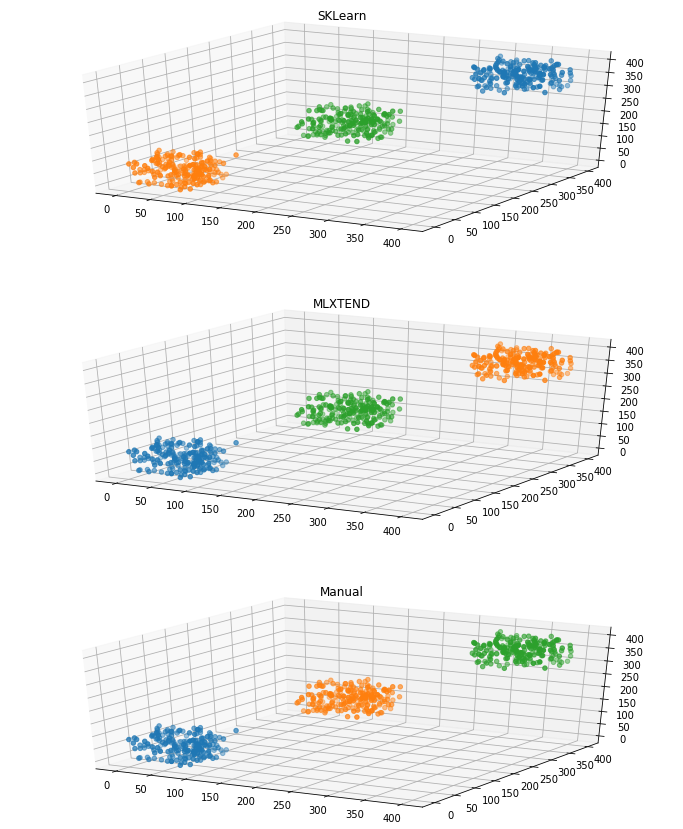

In [210]:
# Testing all implementations on dummy clusterered data

#cluster 1
x = [random.randint(0,100) for _ in range(200)]
y = [random.randint(0,100) for _ in range(200)]
z = [random.randint(0,100) for _ in range(200)]

#cluster 2
x += [random.randint(150,250) for _ in range(200)]
y += [random.randint(150,250) for _ in range(200)]
z += [random.randint(150,250) for _ in range(200)]

#cluster 3
x += [random.randint(300,400) for _ in range(200)]
y += [random.randint(300,400) for _ in range(200)]
z += [random.randint(300,400) for _ in range(200)]

testClusters_df = pd.DataFrame(
    {'x': x,
     'y': y,
     'z': z
    })

# Looking for 3 clusters
k = 3
classes = ['x','y','z']

# find clusters with each implementation
sk_clusters = scikitlearnClustering(testClusters_df, classes, k)
mlx_clusters = mlxtendClustering(testClusters_df, classes, k)
man_clusters = manualClustering(testClusters_df, classes, k)

# plot the clusters with different colours to view the assignment of each implementation
fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(3, 1, 1, projection='3d')
for k_ in range(k):
    ax.scatter(sk_clusters[k_][0],sk_clusters[k_][1],sk_clusters[k_][2])
plt.title("SKLearn")

ax = fig.add_subplot(3, 1, 2, projection='3d')
for k_ in range(k):
    ax.scatter(mlx_clusters[k_][0],mlx_clusters[k_][1],mlx_clusters[k_][2])
plt.title("MLXTEND")

ax = fig.add_subplot(3, 1, 3, projection='3d')
for k_ in range(k):
    ax.scatter(man_clusters[k_][0],man_clusters[k_][1],man_clusters[k_][2])
plt.title("Manual")

plt.show()

#### 5.1.1 Comparing Training Runtime



Text(0.5, 1.0, 'Training Time')

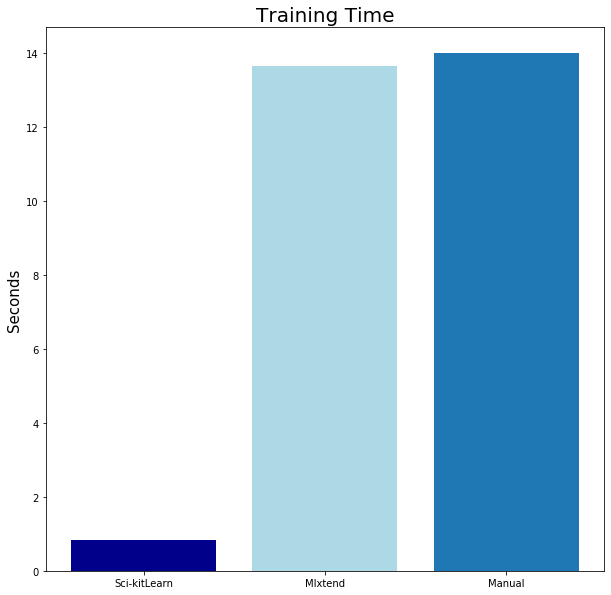

In [211]:
# For testing runtime
classes = [attributes[0], attributes[1]]

start = time.clock()
sk_clusters = scikitlearnClustering(kmc_norm_df, classes, k)
end = time.clock()
sciKitDuration = end - start

start = time.clock()
mlx_clusters = mlxtendClustering(kmc_norm_df, classes, k)
end = time.clock()
mlxDuration = end - start

start = time.clock()
man_clusters = manualClustering(kmc_norm_df, classes, k)
end = time.clock()
manDuration = end - start

plt.figure(figsize=(10,10))
plt.bar('Sci-kitLearn',sciKitDuration,color='darkblue')
plt.bar('Mlxtend', mlxDuration, color='lightblue')
plt.bar('Manual',manDuration)
plt.ylabel('Seconds',fontsize=15)
plt.title("Training Time",fontsize=20)


#### 5.1.2 Comparing Cluster Quality

Analysing cluster quality can be quite limited when ground truth's about the nature of clusters is unknown. No ground truth's are known with our data so the quality of the clusters can only be assessed with the model itself. These metrics essentially quantify a ratio of large distances between cluster centers, and small distances between data points in the same cluster. One of the most common metrics to quantify this quality is the Davies Bouldin Index.

#### Davies Bouldin Index

The Davies Bouldin Index of a set of clusters is calculated as follows:

$$ DB=\frac{1}{N}\sum_{i=1}^ND_i $$

Where N is the number of clusters and $D_i$ is a measure of how good the clustering scheme is for the cluster i.

$D_i$ is calculated as:

$$ D_i=max_{j\neq i}R_{i,j} $$

Where i is the cluster being considered and j is the cluster whose ratio of inter-cluster tightness and intra-cluster center distance is maximised (the worst).
Finally $R_{i,j}$ is calculated as:

$$ R_{i,j} = \frac{S_i+S_j}{M_{i,j}} $$

Where $S_i$ is the average distance between all data points in the cluster i, $S_j$ is the average distance between all data points in the cluster j, and $M_{i,j}$ is the distance between cluster centers i and j.

The lower the DB score, the higher quality the clusters are. Below we use the sklearn implementation of this algorithm to calculate the cluster quality of each implementation. Using the same 2 attributes, we attempt to cluster into groups of k = 2, 4 and 6. Results are graphed below, demonstrating that skLearn consistently generates the highest quality clusters.

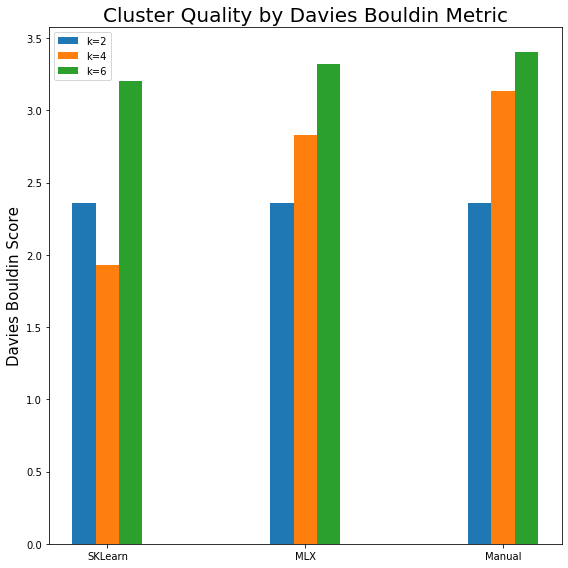

In [212]:
# We will test on the attributes 6 and 7
classes = [attributes[6], attributes[7]]

labels = ['SKLearn', 'MLX', 'Manual']

# Firstly find 2 clusters
k = 2

# Get cluster labels from all implementations
sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
mlx_labels = mlxtendClustering(kmc_norm_df, classes, k, True)

manCls = ManualKMeansCluster(k)
manCls.fit(kmc_norm_df[classes].dropna().to_numpy())
man_labels = manCls.clusters

# Get the davies bouldin scores for each of the results
k2Scores = [sklearn.metrics.davies_bouldin_score(kmc_norm_df, sk_labels),
           sklearn.metrics.davies_bouldin_score(kmc_norm_df, mlx_labels),
           sklearn.metrics.davies_bouldin_score(kmc_norm_df, man_labels)]

# Repeat with k = 4
k = 4

sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
mlx_labels = mlxtendClustering(kmc_norm_df, classes, k, True)

manCls = ManualKMeansCluster(k)
manCls.fit(kmc_norm_df[classes].dropna().to_numpy())
man_labels = manCls.clusters

k4Scores = [sklearn.metrics.davies_bouldin_score(kmc_norm_df, sk_labels),
           sklearn.metrics.davies_bouldin_score(kmc_norm_df, mlx_labels),
           sklearn.metrics.davies_bouldin_score(kmc_norm_df, man_labels)]

# Repeat with k = 6
k = 6

sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
mlx_labels = mlxtendClustering(kmc_norm_df, classes, k, True)

manCls = ManualKMeansCluster(k)
manCls.fit(kmc_norm_df[classes].dropna().to_numpy())
man_labels = manCls.clusters

k6Scores = [sklearn.metrics.davies_bouldin_score(kmc_norm_df, sk_labels),
           sklearn.metrics.davies_bouldin_score(kmc_norm_df, mlx_labels),
           sklearn.metrics.davies_bouldin_score(kmc_norm_df, man_labels)]

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars
spacing = 0.35

# Plot the results as separate rectangles for each k value, with each implementation grouped
fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - spacing/3, k2Scores, width, label='k=2')
rects2 = ax.bar(x, k4Scores, width, label='k=4')
rects3 = ax.bar(x + spacing/3, k6Scores, width, label='k=6')

ax.set_ylabel('Davies Bouldin Score',fontsize=15)
ax.set_title('Cluster Quality by Davies Bouldin Metric',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

#### Silhouette Coefficient

The silhouette coefficient is similar to the Davies Bouldin Score, except instead of considering the mean distances between points within clusters, it also consideres the distance between points in neighbouring clusters. Thus it is more complicated and a much more expensive process. It gives a ratio of how well points are assigned to their current cluster, to how well they would be assigned to their second closest cluster. The first step of calculating this value is to calculate how dissimilar a point i is to it's own cluster:

$$ a(i) = \frac{1}{|C_i|-1}\sum_{j\in C_i,i\neq j}d(i,j) $$

This is the mean distance between point i and all other points in the same cluster.

$$ b(i) = min_{k\neq i}\frac{1}{|C_k|}\sum_{j\in C_k}d(i,j)$$

This is the smallest mean distance between i and all the points in another cluster. This makes this i's neighbouring cluster as it is the second most fitting cluster for i.

Once these values have been calculated the silhouette of point i is:

$$ s(i)=\frac{b(i)-a(i)}{max\{a(i),b(i)\}}, if|C_i|>1 $$

Calculating the silhoutte value for an entire dataset involves taking the average of the silhoutte values for all points. Larger silhouette values closer to 1 mean that b(i) is greater than a(i). A low a(i) value means that the point i is very similar to the other points in it's cluster, which is a good thing. A large b(i) means that the point i is dissimilar to the points in its closest neighbouring cluster, which is also good. This means that larger silhouette values represent higher quality clusters, values around 0 mean the point could be assigned to either cluster, and values close to -1 mean that the point should be in the neighbouring cluster.

Below we test the silhouette coefficient on the same clusters, with k being 2,4 and 6. Once again we see SKLearn perform the best, scoring larger than the other 2 implementations for all k values. 

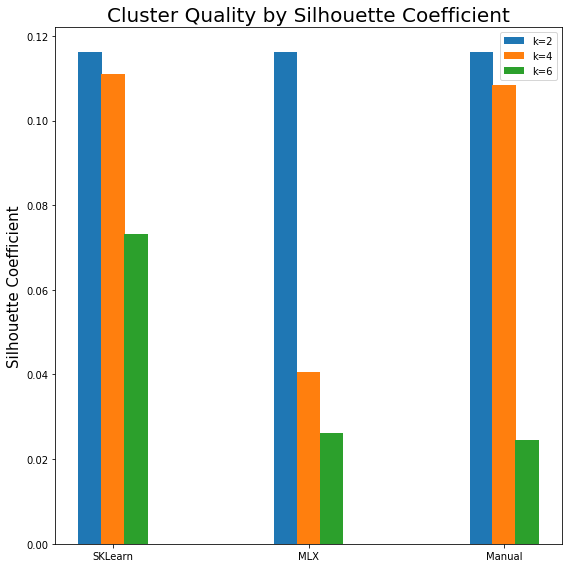

In [213]:
# We will test on the attributes 6 and 7
classes = [attributes[6], attributes[7]]

# Firstly find 2 clusters
k = 2

# Get cluster labels from all implementations
sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
mlx_labels = mlxtendClustering(kmc_norm_df, classes, k, True)

manCls = ManualKMeansCluster(k)
manCls.fit(kmc_norm_df[classes].dropna().to_numpy())
man_labels = manCls.clusters

# Get the silhouette score for each of the results
k2Scores = [sklearn.metrics.silhouette_score(kmc_norm_df, sk_labels, metric='euclidean'),
           sklearn.metrics.silhouette_score(kmc_norm_df, mlx_labels, metric='euclidean'),
           sklearn.metrics.silhouette_score(kmc_norm_df, man_labels, metric='euclidean')]

# Repeat for k = 4
k = 4

sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
mlx_labels = mlxtendClustering(kmc_norm_df, classes, k, True)

manCls = ManualKMeansCluster(k)
manCls.fit(kmc_norm_df[classes].dropna().to_numpy())
man_labels = manCls.clusters

k4Scores = [sklearn.metrics.silhouette_score(kmc_norm_df, sk_labels, metric='euclidean'),
           sklearn.metrics.silhouette_score(kmc_norm_df, mlx_labels, metric='euclidean'),
           sklearn.metrics.silhouette_score(kmc_norm_df, man_labels, metric='euclidean')]

# Repeat for k = 6
k = 6

sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
mlx_labels = mlxtendClustering(kmc_norm_df, classes, k, True)

manCls = ManualKMeansCluster(k)
manCls.fit(kmc_norm_df[classes].dropna().to_numpy())
man_labels = manCls.clusters

k6Scores = [sklearn.metrics.silhouette_score(kmc_norm_df, sk_labels, metric='euclidean'),
           sklearn.metrics.silhouette_score(kmc_norm_df, mlx_labels, metric='euclidean'),
           sklearn.metrics.silhouette_score(kmc_norm_df, man_labels, metric='euclidean')]

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars
spacing = 0.35

# Plot the results as separate rectangles for each k value, with each implementation grouped
fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - spacing/3, k2Scores, width, label='k=2')
rects2 = ax.bar(x, k4Scores, width, label='k=4')
rects3 = ax.bar(x + spacing/3, k6Scores, width, label='k=6')

ax.set_ylabel('Silhouette Coefficient',fontsize=15)
ax.set_title('Cluster Quality by Silhouette Coefficient',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

#### 5.2 Exploring cluster data

From the comparison of methods we have seen that the skLearn implementation peforms the best in terms of speed and cluster quality. For this reason we will use this library to perform exploration on the dataset. 
To find interesting 2d relationships we decided to iterate through the permutations of 2 attributes. For each we create a cluster and then calculate the Davies Bouldin score. The list of permutations and their scores are returned, where the best 10 are saved to k'n'Best. We then plot the clusters with the highest score for the current k value. 
We've plotted the most interesting clusters by this metric below, with k ranging from 2 to 8.

In [214]:
# Find the most interesting 2D clusters for given k
def getBestClusters(attributes, kmc_norm_df,k,howMany):
    resultsk2 = []
    for i in range(len(attributes)-2):
        for j in range(i+1,len(attributes),1):
            classes = [attributes[i], attributes[j]]
            sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True)
            dbscore = sklearn.metrics.davies_bouldin_score(kmc_norm_df, sk_labels)
            resultsk2.append([i,j,dbscore])
    best = sorted(resultsk2, key=lambda x: x[2])[:howMany]
    return best



In [215]:
k2Best = getBestClusters(attributes, kmc_norm_df, 2, 10)
k3Best = getBestClusters(attributes, kmc_norm_df, 3, 10)
k4Best = getBestClusters(attributes, kmc_norm_df, 4, 10)
k5Best = getBestClusters(attributes, kmc_norm_df, 5, 10)
k6Best = getBestClusters(attributes, kmc_norm_df, 6, 10)
k7Best = getBestClusters(attributes, kmc_norm_df, 7, 10)
k8Best = getBestClusters(attributes, kmc_norm_df, 8, 10)

In [217]:
k2Best

[[1, 9, 0.5408367720179462],
 [1, 6, 0.5430575616860539],
 [1, 12, 0.5430575616860539],
 [1, 13, 0.5430575616860539],
 [1, 14, 0.5430575616860539],
 [1, 15, 0.5430575616860539],
 [1, 7, 0.5443826843557671],
 [1, 11, 0.547069079852195],
 [1, 8, 0.5488683667193716],
 [1, 10, 0.5488683667193716]]

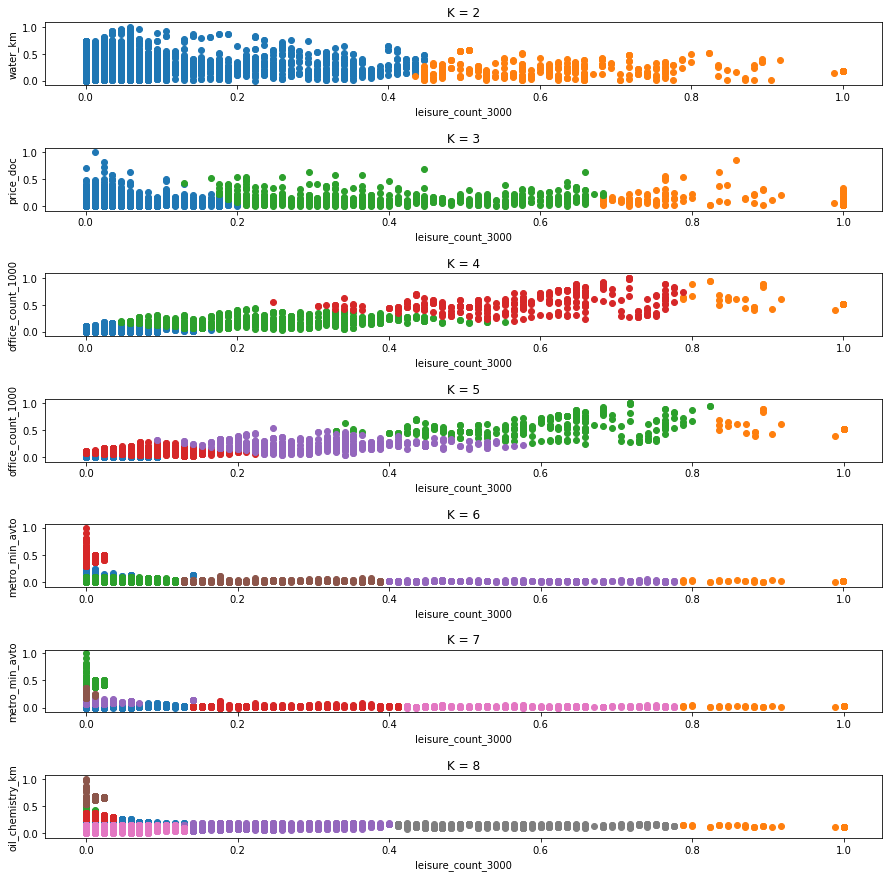

In [218]:
fig = plt.figure(figsize=(15,15))

#k = 2
k=2
# Choose the attributes which produced the best cluster quality
classes = [attributes[k2Best[0][0]], attributes[k2Best[0][1]]]
# Create the cluster and then plot it
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 1)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 2")
plt.xlabel(attributes[k2Best[0][0]])
plt.ylabel(attributes[k2Best[0][1]])

#k = 3
k=3
classes = [attributes[k3Best[0][0]], attributes[k3Best[0][1]]]
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 2)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 3")
plt.xlabel(attributes[k3Best[0][0]])
plt.ylabel(attributes[k3Best[0][1]])

#k = 4
k=4
classes = [attributes[k4Best[0][0]], attributes[k4Best[0][1]]]
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 3)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 4")
plt.xlabel(attributes[k4Best[0][0]])
plt.ylabel(attributes[k4Best[0][1]])

#k = 5
k=5
classes = [attributes[k5Best[0][0]], attributes[k5Best[0][1]]]
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 4)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 5")
plt.xlabel(attributes[k5Best[0][0]])
plt.ylabel(attributes[k5Best[0][1]])

#k = 6
k=6
classes = [attributes[k6Best[0][0]], attributes[k6Best[0][1]]]
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 5)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 6")
plt.xlabel(attributes[k6Best[0][0]])
plt.ylabel(attributes[k6Best[0][1]])

#k = 7
k=7
classes = [attributes[k7Best[0][0]], attributes[k7Best[0][1]]]
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 6)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 7")
plt.xlabel(attributes[k7Best[0][0]])
plt.ylabel(attributes[k7Best[0][1]])

#k = 8
k=8
classes = [attributes[k8Best[0][0]], attributes[k8Best[0][1]]]
skclusters = scikitlearnClustering(kmc_norm_df, classes, k)
plt.subplot(7, 1, 7)
for k_ in range(k):
    plt.scatter(skclusters[k_][0],skclusters[k_][1])
plt.title("K = 8")
plt.xlabel(attributes[k8Best[0][0]])
plt.ylabel(attributes[k8Best[0][1]])

plt.subplots_adjust(hspace = 1)

plt.show()

Seeing as k-means often falls into local minima, random restarts to produce different initial cluster centers can be used to try and converge on different clusters. Below we attempt to produce new clusters, but despite changing the seed both configurations produce the same clusters with the same quality score. It seems that without significant clusters for the algorithm to either find or miss, the global maxima is quite easy to find when the data lacks complexity.

In [219]:
k = 2
numRestarts = 2

silScores = []

#for 2 different sets of attributes
for j in range(2):
    #set classes as price_doc and some other attribute
    classes = [attributes[15], attributes[j]]
    silScores.append([])
    for i in range(numRestarts):
        sk_labels = scikitlearnClustering(kmc_norm_df, classes, k, True, random_state = i)
        sil_score = sklearn.metrics.silhouette_score(kmc_norm_df, sk_labels, metric='euclidean')
        silScores[j].append(sil_score)

In [155]:
#                  | Silhouette Score 1 | Silhouette Score 2  |
#prom_part_5000    |0.14875059540925792 |0.14875059540925792  |
#leisure_count_3000|0.5499695117937881  |0.5499695117937881   |